<a href="https://colab.research.google.com/github/Sanim27/Cifar10_Resnet9/blob/main/Cifar_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import tarfile
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
import os


In [45]:
from torchvision.datasets.utils import download_url
dataset_url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

In [46]:
download_url(dataset_url, '.')
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')
data_dir='./data/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+'/train')
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train']
['horse', 'bird', 'cat', 'deer', 'airplane', 'truck', 'ship', 'dog', 'automobile', 'frog']


In [47]:
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms=tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])
val_tfms=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [48]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
val_ds=ImageFolder(data_dir+'/test',val_tfms)

In [49]:
batch_size=400

In [50]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)

In [51]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def show_batch(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([]);ax.set_yticks([])
    denorm_images=denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
    break

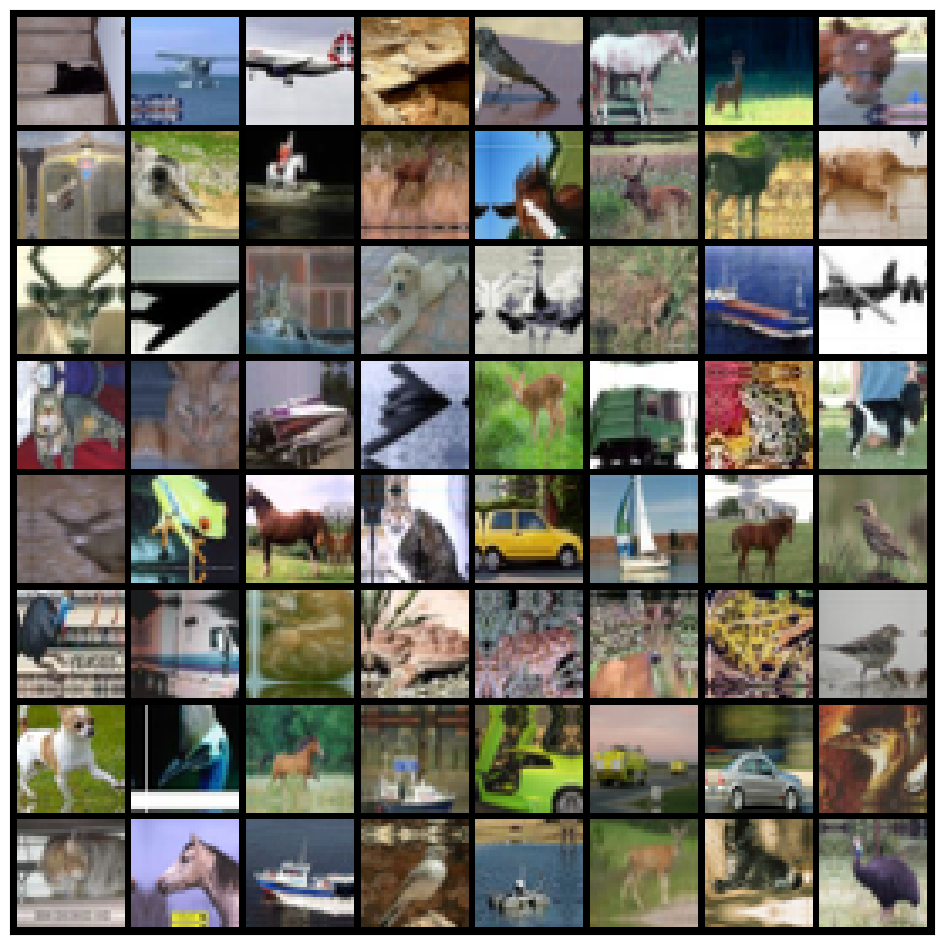

In [52]:
show_batch(train_dl)

In [53]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [54]:
device=get_default_device()
device

device(type='cuda')

In [55]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [56]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1=nn.ReLU()
    self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()
  def forward(self,x):
    out=self.conv1(x)
    out=self.relu1(out)
    out=self.conv2(out)
    return self.relu2(out)+x

In [57]:
simple_resnet = SimpleResidualBlock()
simple_resnet = to_device(simple_resnet, device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


In [58]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [59]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [60]:
def conv_block(in_channels,out_channels,pool=False):
  layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
          ]
  if pool:layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    # 3 x 32 x 32
    self.conv1=conv_block(in_channels,64) # 64 x 32 x 32
    self.conv2=conv_block(64,128,pool=True) # 128 x 16 x 16
    self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128)) # 128 x 16 x 16

    self.conv3=conv_block(128,256,pool=True) # 256 x 8 x 8
    self.conv4=conv_block(256,512,pool=True) # 256 x 4 x 4
    self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512)) #512 x 4 x 4

    self.classifier=nn.Sequential(nn.MaxPool2d(4),
                                  nn.Flatten(),
                                  nn.Dropout(0.2),
                                  nn.Linear(512,num_classes))
  def forward(self,xb):
    out=self.conv1(xb)
    out=self.conv2(out)
    out=self.res1(out)+out
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.res2(out)+out
    out=self.classifier(out)
    return out

In [61]:
model=to_device(Resnet9(3,10),device)

In [62]:
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [63]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]
  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    #training phase
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      #grad clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)
      optimizer.step()
      optimizer.zero_grad()

      #record & update lr
      lrs.append(get_lr(optimizer))
      sched.step()

    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [64]:
history=evaluate(model,val_dl)
history

{'val_loss': 2.3047428131103516, 'val_acc': 0.09586538374423981}

In [65]:
epochs=8
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [66]:
history=[]

In [67]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss: 1.4966, val_loss: 1.7831, val_acc: 0.5099
Epoch [1], train_loss: 1.0928, val_loss: 1.2492, val_acc: 0.6190
Epoch [2], train_loss: 0.8640, val_loss: 0.9156, val_acc: 0.6961
Epoch [3], train_loss: 0.6491, val_loss: 0.6756, val_acc: 0.7655
Epoch [4], train_loss: 0.5269, val_loss: 0.4875, val_acc: 0.8339
Epoch [5], train_loss: 0.4031, val_loss: 0.4169, val_acc: 0.8562
Epoch [6], train_loss: 0.3013, val_loss: 0.3007, val_acc: 0.8965
Epoch [7], train_loss: 0.2276, val_loss: 0.2836, val_acc: 0.9037
CPU times: user 22.6 s, sys: 4.18 s, total: 26.8 s
Wall time: 5min 11s


In [68]:
def plot_accuracies(history):
  accuracies=[x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

In [69]:
def plot_losses(history):
  train_losses=[x.get('train_loss') for x in history]
  val_losses=[x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])

In [70]:
history+=fit_one_cycle(16,max_lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss: 0.2544, val_loss: 0.4172, val_acc: 0.8625
Epoch [1], train_loss: 0.3709, val_loss: 0.8070, val_acc: 0.7649
Epoch [2], train_loss: 0.4944, val_loss: 0.7392, val_acc: 0.7505
Epoch [3], train_loss: 0.5352, val_loss: 0.6415, val_acc: 0.7835
Epoch [4], train_loss: 0.5214, val_loss: 0.6821, val_acc: 0.7754
Epoch [5], train_loss: 0.5001, val_loss: 0.7540, val_acc: 0.7608
Epoch [6], train_loss: 0.4675, val_loss: 0.6915, val_acc: 0.7703
Epoch [7], train_loss: 0.4390, val_loss: 0.5170, val_acc: 0.8250
Epoch [8], train_loss: 0.4153, val_loss: 0.5946, val_acc: 0.8088
Epoch [9], train_loss: 0.3760, val_loss: 0.5076, val_acc: 0.8343
Epoch [10], train_loss: 0.3315, val_loss: 0.3851, val_acc: 0.8699
Epoch [11], train_loss: 0.2785, val_loss: 0.3612, val_acc: 0.8804
Epoch [12], train_loss: 0.2227, val_loss: 0.3164, val_acc: 0.8963
Epoch [13], train_loss: 0.1685, val_loss: 0.2537, val_acc: 0.9168
Epoch [14], train_loss: 0.1253, val_loss: 0.2426, val_acc: 0.9219
Epoch [15], train_lo

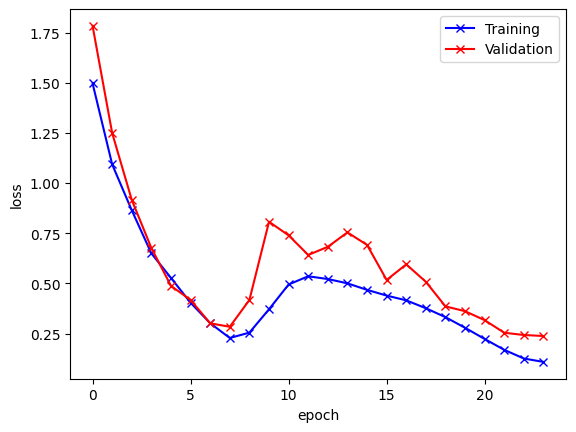

In [71]:
plot_losses(history)

In [72]:
def plot_lrs(history):
  lrs=[x.get('lrs',0) for x in history]
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

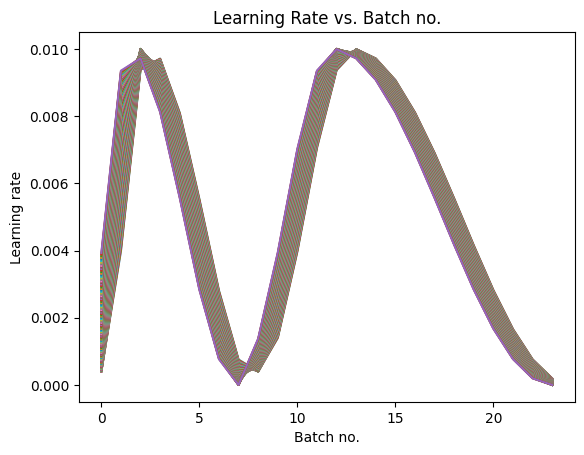

In [73]:
plot_lrs(history)

In [76]:
def predict_image(img,model):
  #turn image into tensor
  xb=img.unsqueeze(0).to('cuda')
  yb=model(xb)
  _,preds=torch.max(yb,dim=1)
  return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


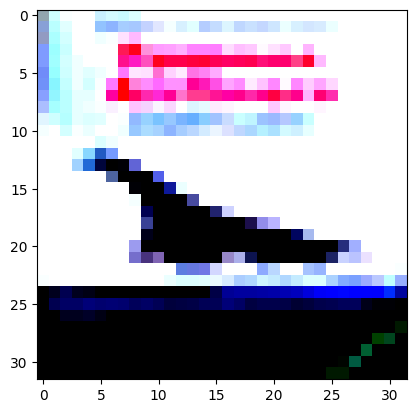

In [77]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


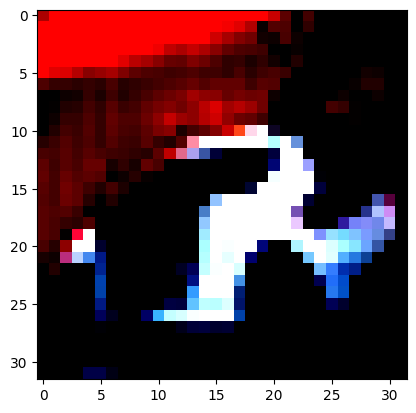

In [78]:
img, label = val_ds[1000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: bird , Predicted: bird


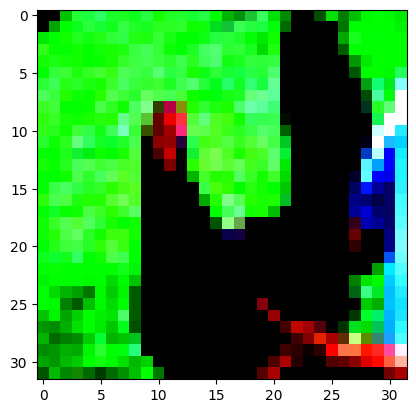

In [79]:
img, label = val_ds[2000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: bird , Predicted: bird


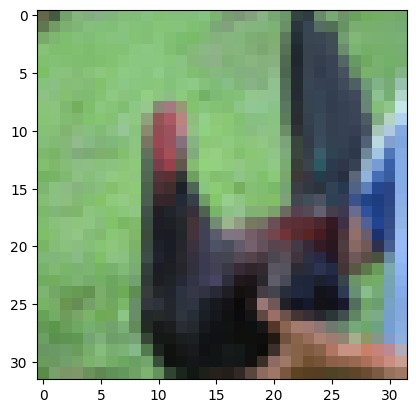

In [82]:
img,label=val_ds[2000]
denorm_image=denormalize(img, *stats)
denorm_image = denorm_image.squeeze()
plt.imshow(denorm_image.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


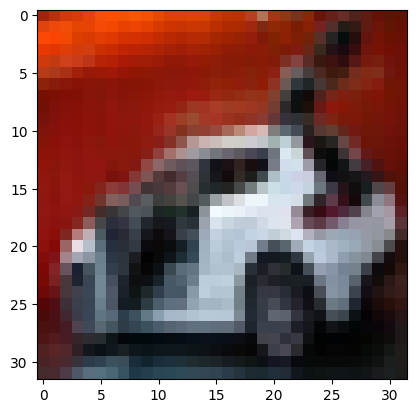

In [83]:
img,label=val_ds[1000]
denorm_image=denormalize(img, *stats)
denorm_image = denorm_image.squeeze()
plt.imshow(denorm_image.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))